# PDC Analysis

## Purpose:
This analysis aims to investigate an adherence measure known as PDC (percent days covered) and determine whether Cureatr treatment may influence more positive post-discharge 30 and 90-day PDC changes than those occurring in untreated patients.

## Background:
- Patients included in this PDC investigation fell into three clinical categories: Hyperlipidemia, Diabetes, and High Blood Pressure
- Patients were included in these categories based on medications taken as follows:

|| Hyperlipidemia | Diabetes | Hypertension |
|----------------|---|---|---|
|| - HMG CoA Reductase Inhibitors<br>- HMG CoA Reductase Inhibitor Combinations | - Incretin Mimetic Agents (GLP-1 Receptor Agonists)<br>- Sulfonylureas<br>  - Sulfonylurea-Biguanide Combinations<br> - Biguanides<br> - Dipeptidyl Peptidase-4 Inhibitor-Biguanide Combinations<br> - Meglitinide-Biguanide Combinations<br> - Sodium-Glucose Co-Transporter 2 Inhibitor-Biguanide Comb<br> - Meglitinide Analogues<br> - Thiazolidinediones<br> - DPP-4 Inhibitor-Thiazolidinedione Combinations<br> - Sodium-Glucose Co-Transporter 2 (SGLT2) Inhibitors<br> - SGLT2 Inhibitor - DPP-4 Inhibitor Combinations<br> - DPP-4 Inhibitor-HMG CoA Reductase Inhibitor Comb | - ACE Inhibitors<br> - Angiotensin Receptor Blockers<br> - Beta Blockers<br> - Calcium Channel Blockers<br> - Diuretics<br> - Aldosterone Antagonists |


In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import sqlalchemy as sa
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt

In [2]:
engine = sa.create_engine("postgresql+psycopg2://")
sql = sa.text('SELECT * FROM pdc_analysis')
results = engine.execute(sql)
full_pdc = pd.DataFrame(results)

## Data Cleaning

In [3]:
#full_pdc.head()

In [4]:
full_pdc.dtypes

patient_opportunity_id                object
patient_id                            object
pid                                   object
iid                                   object
discharge_event_id                    object
discharge_date                datetime64[ns]
followup_record_created_90    datetime64[ns]
discharge_record_created              object
discharge_90_date                      int64
record_created                         int64
discharge_month                       object
discharge_week                        object
category                              object
discharge_pdc                         object
followup_pdc_30                       object
followup_pdc_90                       object
pdc_change_30                         object
pdc_change_90                         object
visit_date                            object
treated                                int64
dtype: object

In [5]:
column_list = ['discharge_pdc', 'followup_pdc_30', 'followup_pdc_90', 'pdc_change_30', 'pdc_change_90']

for column in column_list:
    full_pdc[column] = full_pdc[column].astype('float')

In [6]:
full_pdc.dtypes

patient_opportunity_id                object
patient_id                            object
pid                                   object
iid                                   object
discharge_event_id                    object
discharge_date                datetime64[ns]
followup_record_created_90    datetime64[ns]
discharge_record_created              object
discharge_90_date                      int64
record_created                         int64
discharge_month                       object
discharge_week                        object
category                              object
discharge_pdc                        float64
followup_pdc_30                      float64
followup_pdc_90                      float64
pdc_change_30                        float64
pdc_change_90                        float64
visit_date                            object
treated                                int64
dtype: object

In [7]:
full_pdc['treated'] = full_pdc['treated'].replace({0: 'Untreated', 1: 'Treated'})

## Summary Statistics for PDC Data

### Aggregate Patient Statistics - All Clinical Categories

In [8]:
# Basic count of disease category for treated and untreated
counts_by_cat = pd.DataFrame(full_pdc[["category","treated"]].value_counts())
sort_by_category = counts_by_cat.sort_values(by='category')
print('Patient Counts by Clinical Category and Treatment Status')
sort_by_category

Patient Counts by Clinical Category and Treatment Status


0
category                           treated       
CARDIOVASCULAR_HIGH_BLOOD_PRESSURE Treated    222
                                   Untreated  138
ENDOCRINE_DIABETES                 Treated     97
                                   Untreated   71
ENDOCRINE_LIPID                    Treated    252
                                   Untreated  155

In [9]:
sum = full_pdc[["discharge_pdc","followup_pdc_30"
    ,"followup_pdc_90","pdc_change_30", "pdc_change_90"]].describe()
print('Aggregate Patient Statistics')
sum

Aggregate Patient Statistics


,discharge_pdc,followup_pdc_30,followup_pdc_90,pdc_change_30,pdc_change_90
count,935.000000,935.000000,935.000000,935.000000,935.000000
mean,87.461176,86.651658,83.318610,-0.809519,-4.142567
std,19.772876,20.145647,22.367733,9.844898,17.866498
min,9.100000,10.000000,8.400000,-51.700000,-75.500000
25%,84.950000,82.700000,77.000000,-3.400000,-9.600000
50%,96.300000,95.900000,93.100000,0.000000,-0.900000
75%,100.000000,100.000000,99.600000,0.300000,0.400000
max,100.000000,100.000000,100.000000,74.900000,90.900000


In [10]:
treated_sum = full_pdc.loc[full_pdc['treated'] == 'Treated', ["discharge_pdc","followup_pdc_30"
    ,"followup_pdc_90","pdc_change_30", "pdc_change_90"]].describe()
print('Aggregate Treated Patient Statistics')
treated_sum

Aggregate Treated Patient Statistics


,discharge_pdc,followup_pdc_30,followup_pdc_90,pdc_change_30,pdc_change_90
count,571.000000,571.000000,571.000000,571.000000,571.000000
mean,87.997723,87.648336,84.543082,-0.349387,-3.454641
std,19.304224,19.525523,22.097367,9.777485,17.597676
min,9.100000,10.000000,8.500000,-51.700000,-75.500000
25%,85.700000,83.750000,80.100000,-3.150000,-8.200000
50%,97.200000,96.900000,94.400000,0.000000,-0.300000
75%,100.000000,100.000000,100.000000,0.300000,0.600000
max,100.000000,100.000000,100.000000,74.900000,90.900000


In [11]:
untreated_sum = full_pdc.loc[full_pdc['treated'] == 'Untreated', ["discharge_pdc","followup_pdc_30"
    ,"followup_pdc_90","pdc_change_30", "pdc_change_90"]].describe()
print('Aggregate Untreated Patient Statistics')
untreated_sum

Aggregate Untreated Patient Statistics


,discharge_pdc,followup_pdc_30,followup_pdc_90,pdc_change_30,pdc_change_90
count,364.000000,364.000000,364.000000,364.000000,364.000000
mean,86.619505,85.088187,81.397802,-1.531319,-5.221703
std,20.485050,21.013831,22.682878,9.920217,18.252371
min,10.300000,10.100000,8.400000,-48.600000,-70.300000
25%,84.575000,79.925000,74.275000,-3.850000,-11.300000
50%,95.150000,93.700000,90.200000,0.000000,-1.900000
75%,100.000000,99.400000,98.225000,0.300000,0.300000
max,100.000000,100.000000,100.000000,68.300000,89.700000


### Hyperlipidemia Patient Statistics

In [12]:
lipid_sum = full_pdc.loc[full_pdc.category == "ENDOCRINE_LIPID",
                         ["discharge_pdc", "followup_pdc_30", "followup_pdc_90", "pdc_change_30", "pdc_change_90"]].describe()
print('Total Hyperlipidemia Patient Statistics')
lipid_sum

Total Hyperlipidemia Patient Statistics


,discharge_pdc,followup_pdc_30,followup_pdc_90,pdc_change_30,pdc_change_90
count,407.000000,407.000000,407.000000,407.000000,407.000000
mean,87.252580,87.514005,85.225553,0.261425,-2.027027
std,19.251644,18.527335,20.214911,11.375911,18.227063
min,10.300000,10.900000,8.700000,-43.100000,-69.600000
25%,83.250000,83.050000,79.550000,-2.700000,-7.900000
50%,96.000000,95.700000,93.800000,0.000000,-0.400000
75%,100.000000,100.000000,99.350000,0.750000,0.950000
max,100.000000,100.000000,100.000000,68.300000,89.700000


In [13]:
lipid_sum_treated = full_pdc.loc[(full_pdc.treated == 'Treated') &
                         (full_pdc.category == "ENDOCRINE_LIPID"),
                         ["discharge_pdc", "followup_pdc_30", "followup_pdc_90", "pdc_change_30", "pdc_change_90"]].describe()
print('Treated Hyperlipidemia Patient Statistics')
lipid_sum_treated

Treated Hyperlipidemia Patient Statistics


,discharge_pdc,followup_pdc_30,followup_pdc_90,pdc_change_30,pdc_change_90
count,252.000000,252.000000,252.000000,252.000000,252.000000
mean,87.759524,88.135317,85.342063,0.375794,-2.417460
std,18.867940,18.236953,20.923345,11.301367,18.033899
min,12.100000,10.900000,8.900000,-42.600000,-69.600000
25%,83.325000,83.125000,79.875000,-2.025000,-6.925000
50%,96.950000,96.550000,94.900000,0.000000,-0.300000
75%,100.000000,100.000000,99.600000,0.500000,0.700000
max,100.000000,100.000000,100.000000,65.300000,77.900000


In [14]:
lipid_sum_untreated = full_pdc.loc[(full_pdc.treated == 'Untreated') &
                         (full_pdc.category == "ENDOCRINE_LIPID"),
                         ["discharge_pdc", "followup_pdc_30", "followup_pdc_90", "pdc_change_30", "pdc_change_90"]].describe()
print('Untreated Hyperlipidemia Patient Statistics')
lipid_sum_untreated

Untreated Hyperlipidemia Patient Statistics


,discharge_pdc,followup_pdc_30,followup_pdc_90,pdc_change_30,pdc_change_90
count,155.000000,155.000000,155.000000,155.000000,155.000000
mean,86.428387,86.503871,85.036129,0.075484,-1.392258
std,19.893913,19.006116,19.071900,11.530425,18.578058
min,10.300000,15.900000,8.700000,-43.100000,-48.000000
25%,83.250000,83.550000,79.250000,-2.950000,-8.550000
50%,94.400000,93.900000,93.100000,0.000000,-0.900000
75%,100.000000,99.850000,98.100000,1.300000,2.550000
max,100.000000,100.000000,100.000000,68.300000,89.700000


### Diabetes Patient Statistics

In [15]:
diabetes_sum = full_pdc.loc[full_pdc.category == "ENDOCRINE_DIABETES",
                         ["discharge_pdc", "followup_pdc_30", "followup_pdc_90", "pdc_change_30", "pdc_change_90"]].describe()
print('Total Diabetes Patient Statistics')
diabetes_sum

Total Diabetes Patient Statistics


,discharge_pdc,followup_pdc_30,followup_pdc_90,pdc_change_30,pdc_change_90
count,168.000000,168.000000,168.000000,168.000000,168.000000
mean,87.212500,84.869048,81.460714,-2.343452,-5.751786
std,20.077485,21.616017,24.592847,10.335977,18.985387
min,9.100000,10.000000,8.500000,-51.700000,-75.500000
25%,84.600000,79.675000,70.475000,-4.700000,-10.575000
50%,96.000000,95.200000,93.750000,0.000000,-0.450000
75%,100.000000,100.000000,100.000000,0.200000,0.300000
max,100.000000,100.000000,100.000000,74.900000,90.900000


In [16]:
diabetes_sum_treated = full_pdc.loc[(full_pdc.treated == 'Treated') &
                         (full_pdc.category == "ENDOCRINE_DIABETES"),
                         ["discharge_pdc", "followup_pdc_30", "followup_pdc_90", "pdc_change_30", "pdc_change_90"]].describe()
print('Treated Diabetes Patient Statistics')
diabetes_sum_treated

Treated Diabetes Patient Statistics


,discharge_pdc,followup_pdc_30,followup_pdc_90,pdc_change_30,pdc_change_90
count,97.000000,97.000000,97.000000,97.000000,97.000000
mean,87.357732,86.115464,83.497938,-1.242268,-3.859794
std,20.917217,21.961758,24.055396,11.175828,20.448725
min,9.100000,10.000000,8.500000,-51.700000,-75.500000
25%,86.700000,80.000000,74.300000,-4.100000,-11.100000
50%,96.200000,97.300000,96.400000,0.000000,0.000000
75%,100.000000,100.000000,100.000000,0.400000,0.800000
max,100.000000,100.000000,100.000000,74.900000,90.900000


In [17]:
diabetes_sum_untreated = full_pdc.loc[(full_pdc.treated == 'Untreated') &
                         (full_pdc.category == "ENDOCRINE_DIABETES"),
                         ["discharge_pdc", "followup_pdc_30", "followup_pdc_90", "pdc_change_30", "pdc_change_90"]].describe()
print('Untreated Diabetes Patient Statistics')
diabetes_sum_untreated

Untreated Diabetes Patient Statistics


,discharge_pdc,followup_pdc_30,followup_pdc_90,pdc_change_30,pdc_change_90
count,71.000000,71.000000,71.000000,71.000000,71.000000
mean,87.014085,83.166197,78.677465,-3.847887,-8.336620
std,19.015364,21.170039,25.213042,8.922185,16.574621
min,17.300000,16.600000,12.500000,-45.400000,-70.300000
25%,84.400000,78.250000,65.350000,-5.450000,-9.600000
50%,95.000000,92.000000,90.500000,-0.100000,-3.300000
75%,100.000000,98.700000,97.950000,0.050000,0.000000
max,100.000000,100.000000,100.000000,6.000000,20.400000


### Hypertension Patient Statistics

In [18]:
bp_sum = full_pdc.loc[full_pdc.category == "CARDIOVASCULAR_HIGH_BLOOD_PRESSURE",
                         ["discharge_pdc", "followup_pdc_30", "followup_pdc_90", "pdc_change_30", "pdc_change_90"]].describe()
print('Total Hypertension Patient Statistics')
bp_sum

Total Hypertension Patient Statistics


,discharge_pdc,followup_pdc_30,followup_pdc_90,pdc_change_30,pdc_change_90
count,360.000000,360.000000,360.000000,360.000000,360.000000
mean,87.813056,86.508611,82.029722,-1.304444,-5.783333
std,20.255847,21.165336,23.468393,7.311774,16.676511
min,11.200000,10.100000,8.400000,-48.600000,-68.100000
25%,85.900000,84.575000,75.900000,-3.850000,-11.600000
50%,96.750000,96.550000,91.900000,0.000000,-1.950000
75%,100.000000,100.000000,99.325000,0.200000,0.000000
max,100.000000,100.000000,100.000000,48.200000,83.400000


In [19]:
bp_sum_treated = full_pdc.loc[(full_pdc.treated == 'Treated') &
                         (full_pdc.category == "CARDIOVASCULAR_HIGH_BLOOD_PRESSURE"),
                         ["discharge_pdc", "followup_pdc_30", "followup_pdc_90", "pdc_change_30", "pdc_change_90"]].describe()
print('Treated Hypertension Patient Statistics')
bp_sum_treated

Treated Hypertension Patient Statistics


,discharge_pdc,followup_pdc_30,followup_pdc_90,pdc_change_30,pdc_change_90
count,222.000000,222.000000,222.000000,222.000000,222.000000
mean,88.547748,87.765315,84.092793,-0.782432,-4.454955
std,19.136612,19.868086,22.570111,6.790931,15.665391
min,14.000000,10.900000,8.800000,-22.600000,-68.100000
25%,85.900000,85.000000,82.425000,-3.475000,-9.650000
50%,98.250000,97.300000,93.300000,0.000000,-1.900000
75%,100.000000,100.000000,100.000000,0.200000,0.000000
max,100.000000,100.000000,100.000000,48.200000,62.400000


In [20]:
bp_sum_untreated = full_pdc.loc[(full_pdc.treated == 'Untreated') &
                         (full_pdc.category == "CARDIOVASCULAR_HIGH_BLOOD_PRESSURE"),
                         ["discharge_pdc", "followup_pdc_30", "followup_pdc_90", "pdc_change_30", "pdc_change_90"]].describe()
print('Untreated Hypertension Patient Statistics')
bp_sum_untreated

Untreated Hypertension Patient Statistics


,discharge_pdc,followup_pdc_30,followup_pdc_90,pdc_change_30,pdc_change_90
count,138.000000,138.000000,138.000000,138.000000,138.000000
mean,86.631159,84.486957,78.710870,-2.144203,-7.920290
std,21.957570,23.031143,24.566355,8.034261,18.039645
min,11.200000,10.100000,8.400000,-48.600000,-64.800000
25%,86.550000,82.725000,69.675000,-4.475000,-17.750000
50%,95.650000,93.700000,88.050000,-0.150000,-2.850000
75%,100.000000,99.050000,98.300000,0.200000,0.000000
max,100.000000,100.000000,100.000000,34.100000,83.400000


## Statistical Analysis

### Hypotheses to be Tested:
- $H_{0}$: 30 and 90-Day post-discharge PDC changes are no different in Cureatr-treated and Cureatr-untreated patients
- $H_{1}$: 30 and 90-Day post-discharge PDC changes are more positive in Cureatr-treated compared to those in Cureatr-untreated patients

### ANOVA

In [21]:
# Basic count of disease category for treated and untreated
pdc_30 = full_pdc[["treated","category", "pdc_change_30"]].copy()
pdc_90 = full_pdc[["treated","category", "pdc_change_90"]].copy()

#### 30 Day Anova Analysis

In [22]:
# Fit the ANOVA model
model = ols('pdc_change_30 ~ C(treated) + C(category)', data=pdc_30).fit()

# Print the ANOVA table
print('30 Day PDC Anova Analysis')
print(sm.stats.anova_lm(model, typ=2))

30 Day PDC Anova Analysis
                   sum_sq     df         F    PR(>F)
C(treated)     284.888020    1.0  2.970442  0.085131
C(category)    924.628213    2.0  4.820410  0.008266
Residual     89290.002040  931.0       NaN       NaN


#### Results of ANOVA:
- The 'Treated' feature does not appear to have a significant effect on 30 Day PDC Change. This suggests that Cureatr treatment does not make a significant difference in 30 Day PDC Changes in patients.
- The 'Category' feature appears to have a significant effect on 30 Day PDC Change. This suggests that there are significant differences between the 30 Day PDC Changes of patients in different clinical categories.

#### Next Steps:
- A Multi Comparison test can be performed on significant findings of the two-way ANOVA analysis. A Tukey HSD test will be performed on the 'Category' feature to determine differences in 30 Day PDC Change between clinical categories.

In [23]:
# Perform Tukey HSD test on the "category" factor for 30 Day PDC
tukey_results = pairwise_tukeyhsd(pdc_30['pdc_change_30'], pdc_30['category'], alpha=0.05)
print("PDC 30 - Category Tukey Test")
print(tukey_results)

PDC 30 - Category Tukey Test
                    Multiple Comparison of Means - Tukey HSD, FWER=0.05                    
              group1                     group2       meandiff p-adj   lower  upper  reject
-------------------------------------------------------------------------------------------
CARDIOVASCULAR_HIGH_BLOOD_PRESSURE ENDOCRINE_DIABETES   -1.039 0.4932 -3.1893 1.1113  False
CARDIOVASCULAR_HIGH_BLOOD_PRESSURE    ENDOCRINE_LIPID   1.5659 0.0704 -0.0992 3.2309  False
                ENDOCRINE_DIABETES    ENDOCRINE_LIPID   2.6049 0.0107  0.4945 4.7153   True
-------------------------------------------------------------------------------------------


#### Results of Multi Comparison Tukey HSD:
- A significant difference has been found between the Diabetes and Hyperlipidemia patients' 30 Day PDC Change averages. This suggests that Hyperlipidemia patients in this cohort showed more positive 30 Day PDC change on average than did Diabetes patients in this cohort.
- No other significant differences were found in the Multi Comparison.

#### 90 Day Anova Analysis

In [24]:
# Fit the ANOVA model
model = ols('pdc_change_90 ~ C(treated) + C(category)', data=pdc_90).fit()

# Print the ANOVA table
print('90 Day PDC Anova Analysis')
print(sm.stats.anova_lm(model, typ=2))

90 Day PDC Anova Analysis
                    sum_sq     df         F    PR(>F)
C(treated)      650.377791    1.0  2.057656  0.151779
C(category)    3182.009369    2.0  5.033599  0.006694
Residual     294267.664376  931.0       NaN       NaN


#### Results:
- The 'Treated' feature does not appear to have a significant effect on 90 Day PDC Change. This suggests that Cureatr treatment does not make a significant difference in 90 Day PDC Changes in patients.
- The 'Category' feature appears to have a significant effect on 90 Day PDC Change. This suggests that there are significant differences between the 90 Day PDC Changes of patients in different clinical categories.

#### Next Steps:
- A Multi Comparison test can be performed on significant findings of the two-way ANOVA analysis. A Tukey HSD test will be performed on the 'Category' feature to determine differences in 90 Day PDC Change between clinical categories.

In [25]:
# Perform Tukey HSD test on the "treated" factor for 90 Day PDC
tukey_results = pairwise_tukeyhsd(pdc_90['pdc_change_90'], pdc_90['category'], alpha=0.05)
print("PDC 90 - Category Tukey Test")
print(tukey_results)

PDC 90 - Category Tukey Test
                    Multiple Comparison of Means - Tukey HSD, FWER=0.05                    
              group1                     group2       meandiff p-adj   lower  upper  reject
-------------------------------------------------------------------------------------------
CARDIOVASCULAR_HIGH_BLOOD_PRESSURE ENDOCRINE_DIABETES   0.0315 0.9998 -3.8701 3.9332  False
CARDIOVASCULAR_HIGH_BLOOD_PRESSURE    ENDOCRINE_LIPID   3.7563 0.0101   0.735 6.7776   True
                ENDOCRINE_DIABETES    ENDOCRINE_LIPID   3.7248 0.0586 -0.1046 7.5541  False
-------------------------------------------------------------------------------------------


#### Results of Multi Comparison Tukey HSD:
- A significant difference has been found between the Hypertension and Hyperlipidemia patients' 90 Day PDC Change averages. This suggests that Hyperlipidemia patients in this cohort showed more positive 90 Day PDC change on average than did Hypertension patients in this cohort.
- No other significant differences were found in the Multi Comparison.

### Chi Squared Testing

In [26]:
# create contingency table
data_crosstab = pd.crosstab(full_pdc["treated"],
                            full_pdc["category"],
                           margins=True, margins_name="Total")

In [27]:
data_crosstab

category,CARDIOVASCULAR_HIGH_BLOOD_PRESSURE,ENDOCRINE_DIABETES,ENDOCRINE_LIPID,Total
treated,,,,
Treated,222,97,252,571
Untreated,138,71,155,364
Total,360,168,407,935


In [28]:
# significance level
alpha = 0.05

# Calculation of Chisquare
chi_square = 0
rows = full_pdc["treated"].unique()
columns = full_pdc["category"].unique()
for i in columns:
    for j in rows:
        O = data_crosstab[i][j]
        E = data_crosstab[i]['Total'] * data_crosstab['Total'][j] / data_crosstab['Total']['Total']
        chi_square += (O-E)**2/E
# The p-value approach
print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
p_value = 1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1))
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."

print("chisquare-score is:", chi_square, " and p value is:", p_value)
print(conclusion)

# The critical value approach
print("\n--------------------------------------------------------------------------------------")
print("Approach 2: The critical value approach to hypothesis testing in the decision rule")
critical_value = stats.chi2.ppf(1-alpha, (len(rows)-1)*(len(columns)-1))
conclusion = "Failed to reject the null hypothesis."
if chi_square > critical_value:
    conclusion = "Null Hypothesis is rejected."

print("chisquare-score is:", chi_square, " and critical value is:", critical_value)
print(conclusion + "\n")

Approach 1: The p-value approach to hypothesis testing in the decision rule
chisquare-score is: 0.9610423967676271  and p value is: 0.618460966933361
Failed to reject the null hypothesis.

--------------------------------------------------------------------------------------
Approach 2: The critical value approach to hypothesis testing in the decision rule
chisquare-score is: 0.9610423967676271  and critical value is: 5.991464547107979
Failed to reject the null hypothesis.



#### Results of Chi-Squared:
Via both approaches, the test failed to reject the null hypothesis. This means that insufficient evidence exists to conclude that treatment status and category are associated with one another.

### T-Testing

#### T-Testing in All Patients

In [29]:
print("T-Test for All Patients, 30-Day PDC")
print(stats.ttest_ind(full_pdc["pdc_change_30"][full_pdc["treated"] == 'Treated'],
                full_pdc["pdc_change_30"][full_pdc["treated"] == 'Untreated']))
print("T-Test for All Patients, 90-Day PDC")
print(stats.ttest_ind(full_pdc["pdc_change_90"][full_pdc["treated"] == 'Treated'],
                full_pdc["pdc_change_90"][full_pdc["treated"] == 'Untreated']))

T-Test for All Patients, 30-Day PDC
Ttest_indResult(statistic=1.7920809974959158, pvalue=0.07344392540202634)
T-Test for All Patients, 90-Day PDC
Ttest_indResult(statistic=1.4755328381894621, pvalue=0.14040672753988467)


#### Results:
This suggests that treated patients do not have significantly more positive 30 or 90 Day PDC Change than untreated patients and suggests that Cureatr treatment does not positively influence patient PDC.

In [30]:
hyperlipidemia = full_pdc.loc[full_pdc['category'] == "ENDOCRINE_LIPID", ["treated","pdc_change_30","pdc_change_90"]]
hypertension = full_pdc.loc[full_pdc['category'] == "CARDIOVASCULAR_HIGH_BLOOD_PRESSURE", ["treated","pdc_change_30","pdc_change_90"]]
diabetes = full_pdc.loc[full_pdc['category'] == "ENDOCRINE_DIABETES", ["treated","pdc_change_30","pdc_change_90"]]

#### T-Testing in Hyperlipidemia Patients

In [31]:
print("T-Test for Hyperlipidemia Patients, 30-Day PDC")
print(stats.ttest_ind(hyperlipidemia["pdc_change_30"][hyperlipidemia["treated"] == 'Treated'],
                hyperlipidemia["pdc_change_30"][hyperlipidemia["treated"] == 'Untreated']))
print("T-Test for Hyperlipidemia Patients, 90-Day PDC")
print(stats.ttest_ind(hyperlipidemia["pdc_change_90"][hyperlipidemia["treated"] == 'Treated'],
                hyperlipidemia["pdc_change_90"][hyperlipidemia["treated"] == 'Untreated']))

T-Test for Hyperlipidemia Patients, 30-Day PDC
Ttest_indResult(statistic=0.2583167041341723, pvalue=0.7962937155993067)
T-Test for Hyperlipidemia Patients, 90-Day PDC
Ttest_indResult(statistic=-0.5505397976292841, pvalue=0.5822527162464906)


#### Results:
This suggests that treated Hyperlipidemia patients do not have significantly more positive 30 or 90 Day PDC Change than untreated Hyperlipidemia patients and suggests that Cureatr treatment does not positively influence PDC in Hyperlipidemia patients.

#### T-Testing in Diabetes Patients

In [32]:
print("T-Test for Diabetes Patients, 30-Day PDC")
print(stats.ttest_ind(diabetes["pdc_change_30"][diabetes["treated"] == 'Treated'],
                diabetes["pdc_change_30"][diabetes["treated"] == 'Untreated']))
print("T-Test for Diabetes Patients, 90-Day PDC")
print(stats.ttest_ind(diabetes["pdc_change_90"][diabetes["treated"] == 'Treated'],
                diabetes["pdc_change_90"][diabetes["treated"] == 'Untreated']))

T-Test for Diabetes Patients, 30-Day PDC
Ttest_indResult(statistic=1.6219215281659223, pvalue=0.10671792464251724)
T-Test for Diabetes Patients, 90-Day PDC
Ttest_indResult(statistic=1.515623247826467, pvalue=0.13151652897018573)


#### Results:
This suggests that treated Diabetes patients do not have significantly more positive 30 or 90 Day PDC Change than untreated Diabetes patients and suggests that Cureatr treatment does not positively influence PDC in Diabetes patients.

#### T-Testing in Hypertension Patients

In [33]:
print("T-Test for Hypertension Patients, 30-Day PDC")
print(stats.ttest_ind(hypertension["pdc_change_30"][hypertension["treated"] == 'Treated'],
                hypertension["pdc_change_30"][hypertension["treated"] == 'Untreated']))
print("T-Test for Hypertension Patients, 90-Day PDC")
print(stats.ttest_ind(hypertension["pdc_change_90"][hypertension["treated"] == 'Treated'],
                hypertension["pdc_change_90"][hypertension["treated"] == 'Untreated']))

T-Test for Hypertension Patients, 30-Day PDC
Ttest_indResult(statistic=1.7227928404457928, pvalue=0.08578955194903913)
T-Test for Hypertension Patients, 90-Day PDC
Ttest_indResult(statistic=1.9241245650850753, pvalue=0.05513142020295476)


#### Results:
This suggests that treated Hypertension patients do not have significantly more positive 30 or 90 Day PDC Change than untreated Hypertension patients and suggests that Cureatr treatment does not positively influence PDC in Hypertension patients.

### Visualizing Results

#### By Clinical Category

In [34]:
categories = ["ENDOCRINE_LIPID", "ENDOCRINE_DIABETES", "CARDIOVASCULAR_HIGH_BLOOD_PRESSURE"]

Hyperlipidemia


,treated,patient_count,discharge_pdc,flag_80_discharge,followup_pdc_30,flag_80_30,pdc_change_30,followup_pdc_90,flag_80_90,pdc_change_90,pct_80,pct_80_30d,pct_80_90d
0,Treated,252,87.76,198,88.14,200,0.38,85.34,189,-2.42,78.57,79.37,75.00
1,Untreated,155,86.43,118,86.50,118,0.08,85.04,115,-1.39,76.13,76.13,74.19


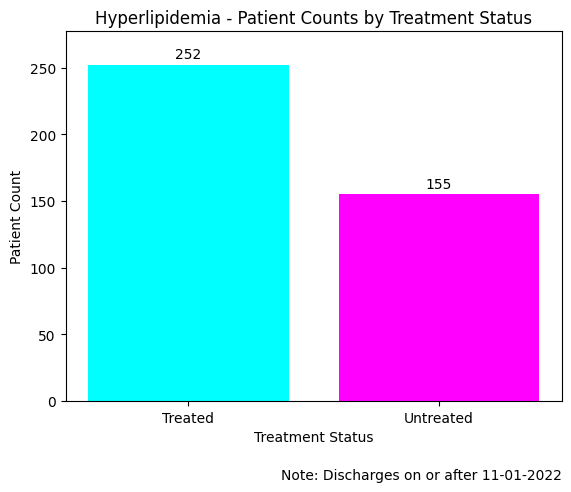

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

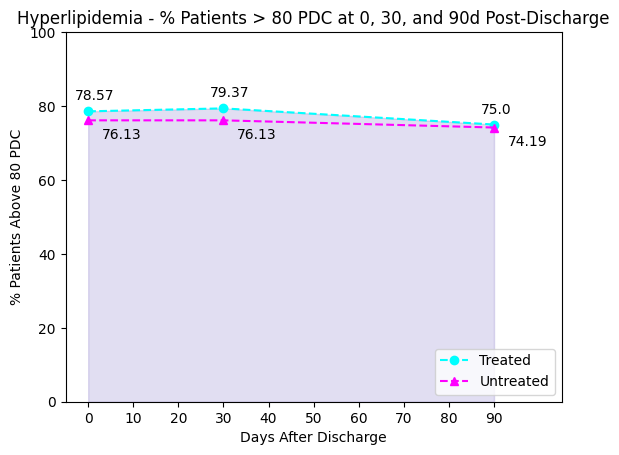

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

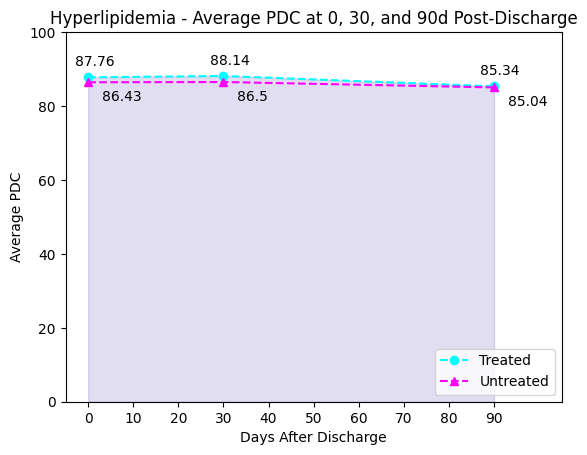

<Figure size 640x480 with 0 Axes>

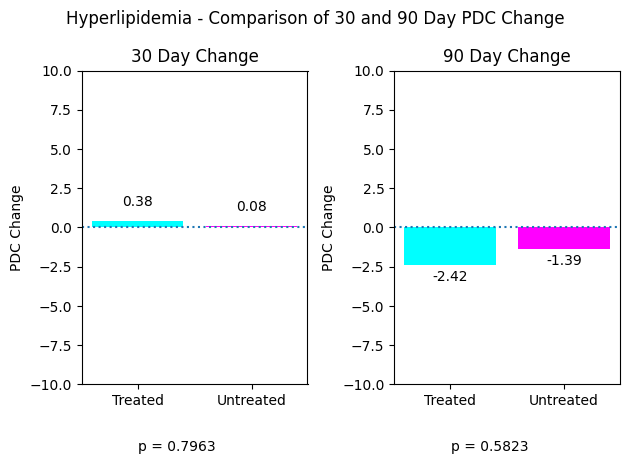

Diabetes


,treated,patient_count,discharge_pdc,flag_80_discharge,followup_pdc_30,flag_80_30,pdc_change_30,followup_pdc_90,flag_80_90,pdc_change_90,pct_80,pct_80_30d,pct_80_90d
0,Treated,97,87.36,79,86.12,73,-1.24,83.50,71,-3.86,81.44,75.26,73.20
1,Untreated,71,87.01,59,83.17,51,-3.85,78.68,45,-8.34,83.10,71.83,63.38


<Figure size 640x480 with 0 Axes>

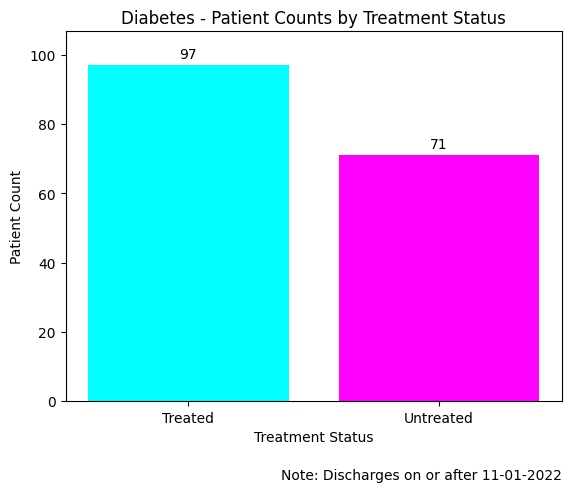

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

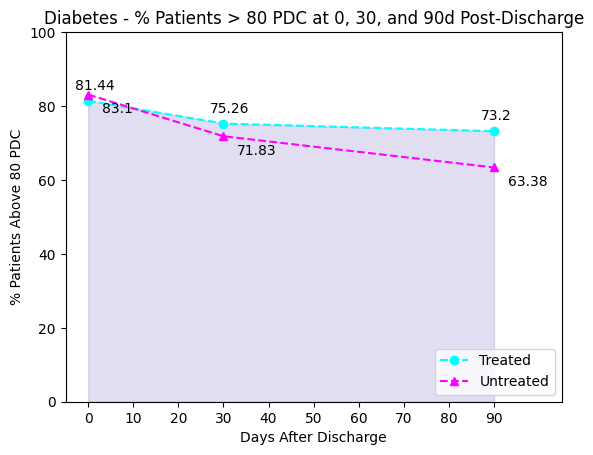

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

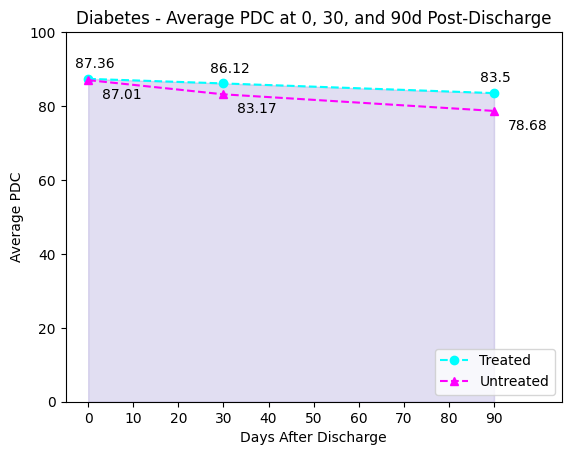

<Figure size 640x480 with 0 Axes>

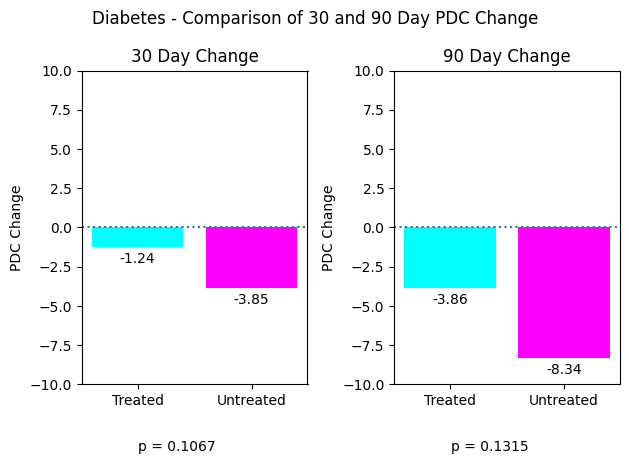

Hypertension


,treated,patient_count,discharge_pdc,flag_80_discharge,followup_pdc_30,flag_80_30,pdc_change_30,followup_pdc_90,flag_80_90,pdc_change_90,pct_80,pct_80_30d,pct_80_90d
0,Treated,222,88.55,179,87.77,176,-0.78,84.09,171,-4.45,80.63,79.28,77.03
1,Untreated,138,86.63,111,84.49,104,-2.14,78.71,85,-7.92,80.43,75.36,61.59


<Figure size 640x480 with 0 Axes>

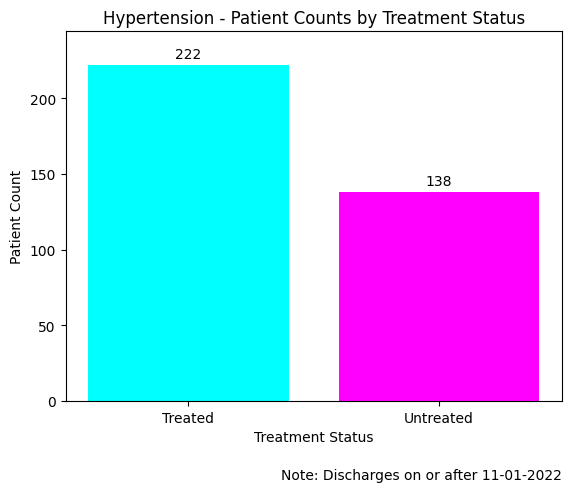

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

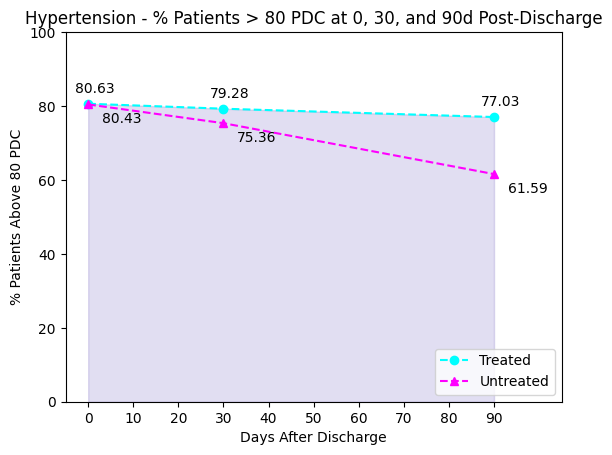

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

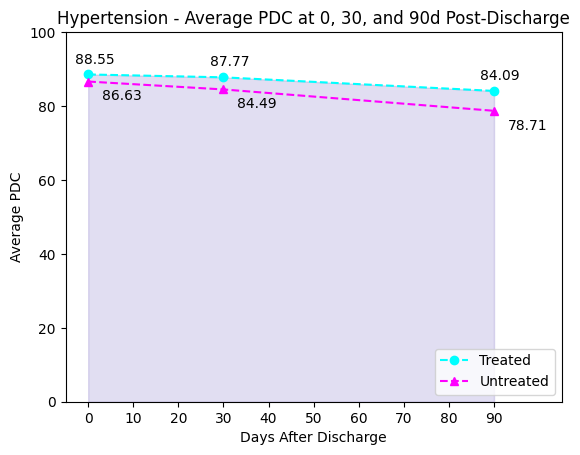

<Figure size 640x480 with 0 Axes>

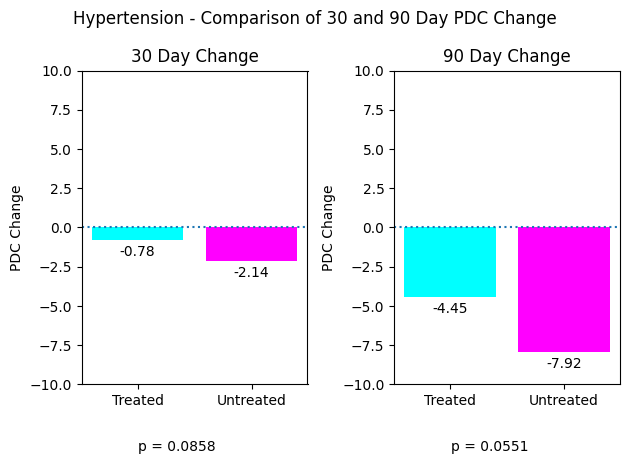

<Figure size 640x480 with 0 Axes>

In [35]:
for category in categories:

    # Create df of each category and aggregate table with metrics to graph
    summary = full_pdc.loc[full_pdc['category'] == category, ["treated", "category", "discharge_pdc", "followup_pdc_30", "pdc_change_30","followup_pdc_90", "pdc_change_90"]].copy()
    summary['flag_80_discharge'] = summary['discharge_pdc'].apply(lambda x: 1 if x >= 80 else 0)
    summary['flag_80_30'] = summary['followup_pdc_30'].apply(lambda x: 1 if x >= 80 else 0)
    summary['flag_80_90'] = summary['followup_pdc_90'].apply(lambda x: 1 if x >= 80 else 0)

    p_values = []
    t_stat_30, p_value_30 = stats.ttest_ind(summary["pdc_change_30"][summary["treated"] == 'Treated'],summary["pdc_change_30"][summary["treated"] == 'Untreated'])
    p_value_30 = p_value_30.round(4)
    p_values.append(p_value_30)
    t_stat_90, p_value_90 = stats.ttest_ind(summary["pdc_change_90"][summary["treated"] == 'Treated'],summary["pdc_change_90"][summary["treated"] == 'Untreated'])
    p_value_90 = p_value_90.round(4)
    p_values.append(p_value_90)

    summary = summary.groupby(['treated']).agg(
        patient_count = ('category', 'count')
        , discharge_pdc = ('discharge_pdc', 'mean')
        , flag_80_discharge = ('flag_80_discharge', 'sum')
        , followup_pdc_30 = ('followup_pdc_30', 'mean')
        , flag_80_30 = ('flag_80_30', 'sum')
        , pdc_change_30 = ('pdc_change_30', 'mean')
        , followup_pdc_90 = ('followup_pdc_90', 'mean')
        , flag_80_90 = ('flag_80_90', 'sum')
        , pdc_change_90 = ('pdc_change_90', 'mean')
    ).reset_index()
    summary['pct_80'] = (summary['flag_80_discharge']/summary['patient_count']) * 100
    summary['pct_80_30d'] = (summary['flag_80_30']/summary['patient_count']) * 100
    summary['pct_80_90d'] = (summary['flag_80_90']/summary['patient_count']) * 100
    summary = summary.round(2)
    disease = ''

    if category == "ENDOCRINE_LIPID":
        disease = 'Hyperlipidemia'
    elif category == "CARDIOVASCULAR_HIGH_BLOOD_PRESSURE":
        disease = 'Hypertension'
    else:
        disease = 'Diabetes'

    pd.set_option('display.max_columns', None)
    print(disease)
    display(summary)
    print("\n")

    cmap = plt.get_cmap('cool')
    colors = [cmap(i) for i in np.linspace(0, 1, len(summary['treated']))]


    # Chart Difference in Patient Count b/w Untreated and Treated
    plt.figure()
    plt.bar(summary['treated'], summary['patient_count'], color=colors)
    filename = f'{disease} - Patient Counts by Treatment Status'
    plt.title(filename)
    plt.annotate('Note: Discharges on or after 11-01-2022',
            xy = (1.0, -0.2),
            xycoords='axes fraction',
            ha='right',
            va="center",
            fontsize=10)
    plt.xlabel('Treatment Status')
    plt.ylabel('Patient Count')
    ymax = max(summary['patient_count'])
    plt.ylim(0,ymax * 1.10)
    for i in range(len(summary['treated'])):
        plt.text(x = i, y = summary['patient_count'][i]+0.02*ymax, s = f"{summary['patient_count'][i]}", ha = 'center')
    plt.show()
    plt.savefig(f"{filename}.png", bbox_inches='tight')

    plt.figure()
    treated_rows = summary[summary['treated'] == 'Treated']
    untreated_rows = summary[summary['treated'] == 'Untreated']
    cols = ['pct_80', 'pct_80_30d', 'pct_80_90d']
    treated_values = treated_rows[cols].values.ravel()
    untreated_values = untreated_rows[cols].values.ravel()
    data = {'timeframe': [0, 30, 90],
            'Treated': treated_values,
            'Untreated': untreated_values}
    df = pd.DataFrame(data)
    df.set_index('timeframe', inplace=True)
    fig, ax = plt.subplots()
    ax.plot(df.index, df['Treated'], label='Treated', linestyle='--', marker='o', c=colors[0])
    ax.plot(df.index, df['Untreated'], label='Untreated', linestyle='--', marker='^', c=colors[1])
    ax.fill_between(df.index, df['Treated'], alpha=0.1, color='c')
    ax.fill_between(df.index, df['Treated'], alpha=0.1, color='m')
    for i, j in df['Treated'].items():
        ax.annotate(str(j), xy=(i-3, j+3))
    for i, j in df['Untreated'].items():
        ax.annotate(str(j), xy=(i+3, j-5))
    ax.set_xlim(-5,105)
    ax.set_ylim(0,100)
    plt.xticks(np.arange(0, 100, 10))
    ax.legend(loc='lower right')
    ax.set_xlabel('Days After Discharge')
    ax.set_ylabel('% Patients Above 80 PDC')
    filename = f'{disease} - % Patients > 80 PDC at 0, 30, and 90d Post-Discharge'
    plt.title(filename)
    plt.show()
    plt.savefig(f"{filename}.png", bbox_inches='tight')

    plt.figure()
    treated_rows = summary[summary['treated'] == 'Treated']
    untreated_rows = summary[summary['treated'] == 'Untreated']
    cols = ['discharge_pdc', 'followup_pdc_30', 'followup_pdc_90']
    treated_values = treated_rows[cols].values.ravel()
    untreated_values = untreated_rows[cols].values.ravel()
    data = {'timeframe': [0, 30, 90],
            'Treated': treated_values,
            'Untreated': untreated_values}
    df = pd.DataFrame(data)
    df.set_index('timeframe', inplace=True)
    fig, ax = plt.subplots()
    ax.plot(df.index, df['Treated'], label='Treated', linestyle='--', marker='o', c=colors[0])
    ax.plot(df.index, df['Untreated'], label='Untreated', linestyle='--', marker='^', c=colors[1])
    ax.fill_between(df.index, df['Treated'], alpha=0.1, color='c')
    ax.fill_between(df.index, df['Treated'], alpha=0.1, color='m')
    for i, j in df['Treated'].items():
        ax.annotate(str(j), xy=(i-3, j+3))
    for i, j in df['Untreated'].items():
        ax.annotate(str(j), xy=(i+3, j-5))
    ax.set_xlim(-5,105)
    ax.set_ylim(0,100)
    plt.xticks(np.arange(0, 100, 10))
    ax.legend(loc='lower right')
    ax.set_xlabel('Days After Discharge')
    ax.set_ylabel('Average PDC')
    filename = f'{disease} - Average PDC at 0, 30, and 90d Post-Discharge'
    plt.title(filename)
    plt.show()
    plt.savefig(f"{filename}.png", bbox_inches='tight')

    plt.figure()
    x_labels = ['30 Day Change', '90 Day Change']
    for i, metric in enumerate(['pdc_change_30', 'pdc_change_90']):
        plt.subplot(1, 2, i+1)
        plt.bar(summary['treated'], summary[metric], color=colors)
        plt.axhline(y = 0, linestyle = 'dotted')
        plt.title(f'{x_labels[i]}')
        plt.ylabel('PDC Change')
        plt.ylim(-10,10)
        plt.annotate(f'p = {p_values[i]}',
            xy = (0.25, -0.2),
            xycoords='axes fraction',
            ha='left',
            va="center",
            fontsize=10)
        for j in range(len(summary['treated'])):
            if summary[metric][j] >= 0:
                plt.text(x = summary['treated'][j], y = summary[metric][j]+1,s=f"{summary[metric][j]}", ha = 'center')
            else:
                plt.text(x = summary['treated'][j], y = summary[metric][j]-1,s=f"{summary[metric][j]}", ha = 'center')
    filename = f'{disease} - Comparison of 30 and 90 Day PDC Change'
    plt.suptitle(filename)
    plt.tight_layout()
    plt.show()
    plt.savefig(f"{filename}.png", bbox_inches='tight')

#### Total Patient Graphs

,treated,patient_count,discharge_pdc,flag_80_discharge,followup_pdc_30,flag_80_30,pdc_change_30,followup_pdc_90,flag_80_90,pdc_change_90,pct_80,pct_80_30d,pct_80_90d
0,Treated,571,88.00,456,87.65,449,-0.35,84.54,431,-3.45,79.86,78.63,75.48
1,Untreated,364,86.62,288,85.09,273,-1.53,81.40,245,-5.22,79.12,75.00,67.31


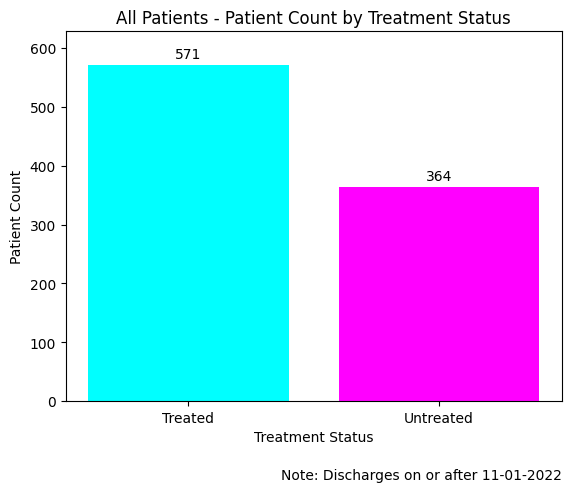

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

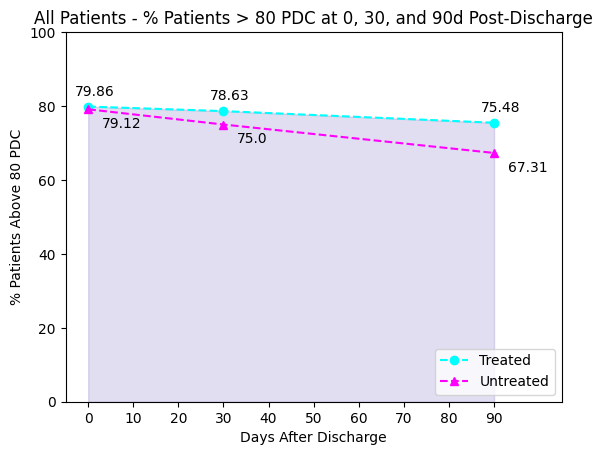

<Figure size 640x480 with 0 Axes>

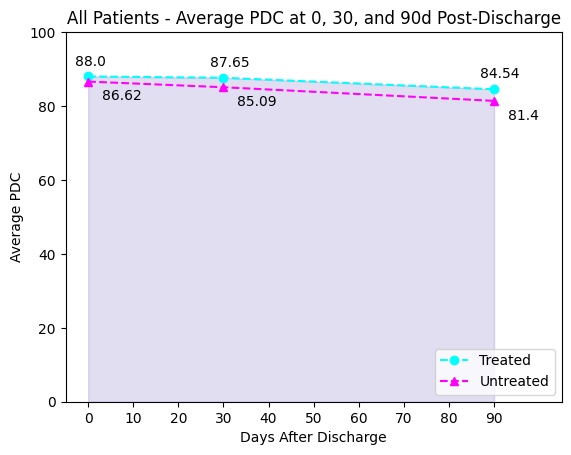

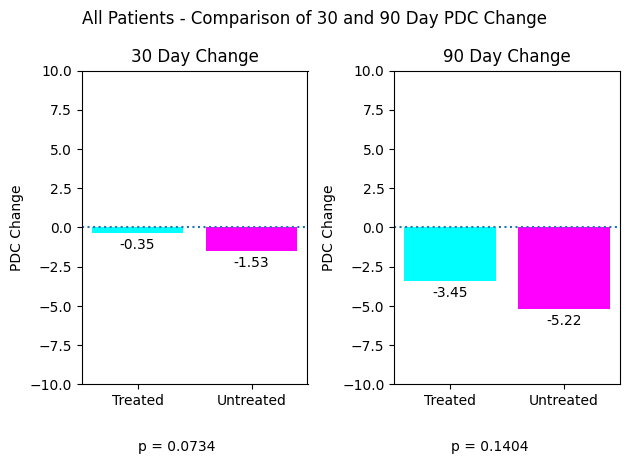

<Figure size 640x480 with 0 Axes>

In [36]:
# Create df of each category and aggregate table with metrics to graph
summary = full_pdc[["treated", "category", "discharge_pdc", "followup_pdc_30",                                                              "pdc_change_30","followup_pdc_90", "pdc_change_90"]].copy()
summary['flag_80_discharge'] = summary['discharge_pdc'].apply(lambda x: 1 if x >= 80 else 0)
summary['flag_80_30'] = summary['followup_pdc_30'].apply(lambda x: 1 if x >= 80 else 0)
summary['flag_80_90'] = summary['followup_pdc_90'].apply(lambda x: 1 if x >= 80 else 0)

p_values = []
t_stat_30, p_value_30 = stats.ttest_ind(summary["pdc_change_30"][summary["treated"] == 'Treated'],summary["pdc_change_30"][summary["treated"] == 'Untreated'])
p_value_30 = p_value_30.round(4)
p_values.append(p_value_30)
t_stat_90, p_value_90 = stats.ttest_ind(summary["pdc_change_90"][summary["treated"] == 'Treated'],summary["pdc_change_90"][summary["treated"] == 'Untreated'])
p_value_90 = p_value_90.round(4)
p_values.append(p_value_90)

summary = summary.groupby(['treated']).agg(
    patient_count = ('category', 'count')
    , discharge_pdc = ('discharge_pdc', 'mean')
    , flag_80_discharge = ('flag_80_discharge', 'sum')
    , followup_pdc_30 = ('followup_pdc_30', 'mean')
    , flag_80_30 = ('flag_80_30', 'sum')
    , pdc_change_30 = ('pdc_change_30', 'mean')
    , followup_pdc_90 = ('followup_pdc_90', 'mean')
    , flag_80_90 = ('flag_80_90', 'sum')
    , pdc_change_90 = ('pdc_change_90', 'mean')
).reset_index()
summary['pct_80'] = (summary['flag_80_discharge']/summary['patient_count']) * 100
summary['pct_80_30d'] = (summary['flag_80_30']/summary['patient_count']) * 100
summary['pct_80_90d'] = (summary['flag_80_90']/summary['patient_count']) * 100
summary = summary.round(2)
pd.set_option('display.max_columns', None)
display(summary)

cmap = plt.get_cmap('cool')
colors = [cmap(i) for i in np.linspace(0, 1, len(summary['treated']))]

# Chart Difference in Patient Count b/w Untreated and Treated
plt.figure()
plt.bar(summary['treated'], summary['patient_count'], color=colors)
filename = 'All Patients - Patient Count by Treatment Status'
plt.title(filename)
plt.annotate('Note: Discharges on or after 11-01-2022',
        xy = (1.0, -0.2),
        xycoords='axes fraction',
        ha='right',
        va="center",
        fontsize=10)
plt.xlabel('Treatment Status')
plt.ylabel('Patient Count')
ymax = max(summary['patient_count'])
plt.ylim(0,ymax * 1.10)
for i in range(len(summary['treated'])):
    plt.text(x = i, y = summary['patient_count'][i]+0.02*ymax, s = f"{summary['patient_count'][i]}", ha = 'center')
plt.show()
plt.savefig(f"{filename}.png", bbox_inches='tight')

plt.figure()
treated_rows = summary[summary['treated'] == 'Treated']
untreated_rows = summary[summary['treated'] == 'Untreated']
cols = ['pct_80', 'pct_80_30d', 'pct_80_90d']
treated_values = treated_rows[cols].values.ravel()
untreated_values = untreated_rows[cols].values.ravel()
data = {'timeframe': [0, 30, 90],
        'Treated': treated_values,
        'Untreated': untreated_values}
df = pd.DataFrame(data)
df.set_index('timeframe', inplace=True)
fig, ax = plt.subplots()
ax.plot(df.index, df['Treated'], label='Treated', linestyle='--', marker='o', c=colors[0])
ax.plot(df.index, df['Untreated'], label='Untreated', linestyle='--', marker='^', c=colors[1])
ax.fill_between(df.index, df['Treated'], alpha=0.1, color='c')
ax.fill_between(df.index, df['Treated'], alpha=0.1, color='m')
for i, j in df['Treated'].items():
    ax.annotate(str(j), xy=(i-3, j+3))
for i, j in df['Untreated'].items():
    ax.annotate(str(j), xy=(i+3, j-5))
ax.set_xlim(-5,105)
ax.set_ylim(0,100)
plt.xticks(np.arange(0, 100, 10))
ax.legend(loc='lower right')
ax.set_xlabel('Days After Discharge')
ax.set_ylabel('% Patients Above 80 PDC')
filename = 'All Patients - % Patients > 80 PDC at 0, 30, and 90d Post-Discharge'
plt.title(filename)
# plt.savefig(f"{filename}.png", bbox_inches='tight')
plt.show()

plt.figure()
treated_rows = summary[summary['treated'] == 'Treated']
untreated_rows = summary[summary['treated'] == 'Untreated']
cols = ['discharge_pdc', 'followup_pdc_30', 'followup_pdc_90']
treated_values = treated_rows[cols].values.ravel()
untreated_values = untreated_rows[cols].values.ravel()
data = {'timeframe': [0, 30, 90],
        'Treated': treated_values,
        'Untreated': untreated_values}
df = pd.DataFrame(data)
df.set_index('timeframe', inplace=True)
fig, ax = plt.subplots()
ax.plot(df.index, df['Treated'], label='Treated', linestyle='--', marker='o', c=colors[0])
ax.plot(df.index, df['Untreated'], label='Untreated', linestyle='--', marker='^', c=colors[1])
ax.fill_between(df.index, df['Treated'], alpha=0.1, color='c')
ax.fill_between(df.index, df['Treated'], alpha=0.1, color='m')
for i, j in df['Treated'].items():
    ax.annotate(str(j), xy=(i-3, j+3))
for i, j in df['Untreated'].items():
    ax.annotate(str(j), xy=(i+3, j-5))
ax.set_xlim(-5,105)
ax.set_ylim(0,100)
plt.xticks(np.arange(0, 100, 10))
ax.legend(loc='lower right')
ax.set_xlabel('Days After Discharge')
ax.set_ylabel('Average PDC')
filename = 'All Patients - Average PDC at 0, 30, and 90d Post-Discharge'
plt.title(filename)
# plt.savefig(f"{filename}.png", bbox_inches='tight')
plt.show()

# Create data for grouped bar chart
n_groups = 2
pdc_change_30 = list(summary['pdc_change_30'])
pdc_change_90 = list(summary['pdc_change_90'])
treated_means = [pdc_change_30[0], pdc_change_90[0]]
untreated_means = [pdc_change_30[1], pdc_change_90[1]]

plt.figure()
x_labels = ['30 Day Change', '90 Day Change']
for i, metric in enumerate(['pdc_change_30', 'pdc_change_90']):
    plt.subplot(1, 2, i+1)
    plt.bar(summary['treated'], summary[metric], color=colors)
    plt.axhline(y = 0, linestyle = 'dotted')
    plt.title(f'{x_labels[i]}')
    plt.ylabel('PDC Change')
    plt.ylim(-10,10)
    plt.annotate(f'p = {p_values[i]}',
        xy = (0.25, -0.2),
        xycoords='axes fraction',
        ha='left',
        va="center",
        fontsize=10)
    for j in range(len(summary['treated'])):
        if summary[metric][j] >= 0:
            plt.text(x = summary['treated'][j], y = summary[metric][j]+1,s=f"{summary[metric][j]}", ha = 'center')
        else:
            plt.text(x = summary['treated'][j], y = summary[metric][j]-1,s=f"{summary[metric][j]}", ha = 'center')

filename = 'All Patients - Comparison of 30 and 90 Day PDC Change'
plt.suptitle(filename)
plt.tight_layout()
plt.show()
plt.savefig(f"{filename}.png", bbox_inches='tight')